In [1]:
import numpy as np
import sys
sys.path.append('./../../designer/script/')
from design import Design
from film import FilmSimple
from spectrum import Spectrum


def make_reflection_design(init_film: FilmSimple):
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500) # when wls = 50, ~100 min
    target_spec = [Spectrum(inc_ang, wls, np.ones(wls.shape[0], dtype='float'))]
    
    design = Design(target_spec, init_film)
    return design

result_d_ls = []
for run_num, init_ot in enumerate(np.linspace(0, 5000, 200)):
    
    d_init = np.array([init_ot], dtype='float')
    film = FilmSimple('SiO2', 'TiO2', 'SiO2', d_init)
    design = make_reflection_design(film)
    try:
        design.TFNN_train(epoch=50)
    except Exception as e:
        print(e.args[0])

    np.savetxt(
        f'./raw_result/single_inc/0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_final', 
        design.film.get_d() / 1000 # in \mu m
    )



c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
c:\Users\rfeng6\Desktop\TFNN\Thin-Film-Design\working\needle_training\./../../designer/script\optimizer\LM_gradient_descent.py:63: RuntimeWarning: invalid value encountered in double_scalars
  rho = (F_d - F_dnew) / np.dot(h.T, mu * h - g).item()


Design terminated: zero layers
0-th iteration, loss: 0.9545036783633585, 6 gd steps


c:\Users\rfeng6\.conda\envs\cuda\lib\site-packages\numba\cuda\dispatcher.py:488: NumbaPerformanceWarning: Grid size 32 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


insert gradient: -1.9865456241651303
0-th iteration, new layer inserted. now 2 layers
[25.12562814  0.        ]
1-th iteration, loss: 0.7465113875206747, 11 gd steps
1-th iteration, new layer inserted. now 4 layers
[2.98971315e+01 7.52391188e+01 0.00000000e+00 3.70814490e-14]
2-th iteration, loss: 0.6598330591444459, 13 gd steps
insert gradient: -0.011180187198537962
2-th iteration, new layer inserted. now 4 layers
[1.20649550e+00 0.00000000e+00 3.26128013e-16 5.52737458e+01]
3-th iteration, loss: 0.6598181064726139, 14 gd steps
3-th iteration, new layer inserted. now 3 layers
[ 1.79889184 55.24403845  0.        ]
4-th iteration, loss: 0.6598180977378222, 7 gd steps
insert gradient: -0.0002516729579486868
4-th iteration, new layer inserted. now 2 layers
[ 1.79629626 55.23511496]
5-th iteration, loss: 0.6598180969660132, 7 gd steps
5-th iteration, new layer inserted. now 4 layers
[1.79710075e+00 5.52377582e+01 0.00000000e+00 1.38777878e-14]
6-th iteration, loss: 0.6598180968911103, 6 gd

C:\Users\rfeng6\AppData\Local\Temp\ipykernel_13436\3791610427.py:4: UserWarning: loadtxt: input contained no data: "./raw_result/single_inc/0_inc-400to1000wls-init_single_layer_SiO2/0_final"
  d = np.loadtxt(f'./raw_result/single_inc/0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_final') * 1000.


(0.0, 1.0)

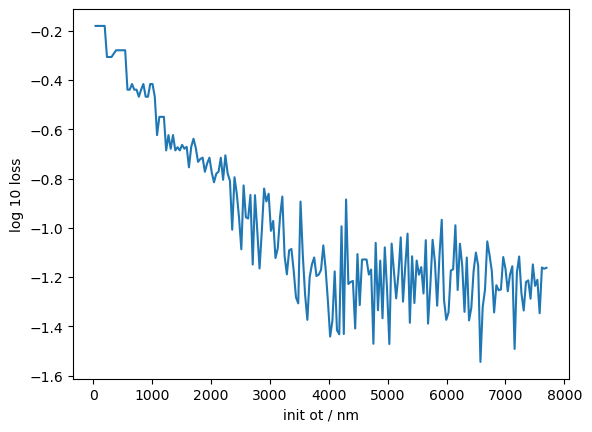

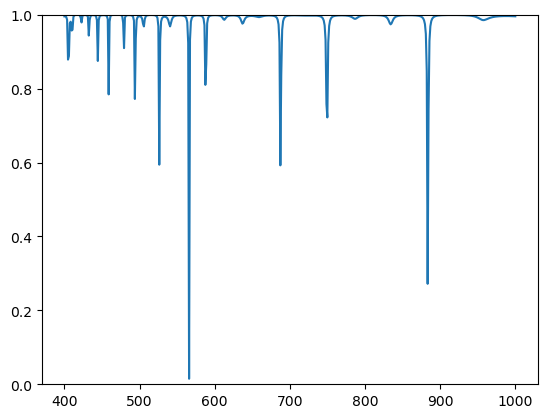

In [16]:
import matplotlib.pyplot as plt
design_ls: list[Design] = []
for run_num, init_gt in enumerate(np.linspace(0, 5000, 200)):
    d = np.loadtxt(f'./raw_result/single_inc/0_inc-400to1000wls-init_single_layer_SiO2/{run_num}_final') * 1000.
    if d.shape == (0, ):
        continue
    f = FilmSimple('SiO2', 'TiO2', 'SiO2', d)
    
    inc_ang = 0.
    wls = np.linspace(400, 1000, 500)
    target_spec = [Spectrum(inc_ang, wls, np.ones(wls.shape[0], dtype='float'))]
    
    design_ls.append(Design(target_spec, FilmSimple('SiO2', 'TiO2', 'SiO2', np.array([init_gt])), f))

init_ot, loss = [], []
for d in design_ls:
    init_ot.append(d.get_init_ot())
    loss.append(d.calculate_loss())
fig, ax = plt.subplots(1, 1)
ax.plot(init_ot, np.log10(loss))
ax.set_xlabel('init ot / nm')
ax.set_ylabel('log 10 loss')


fig, ax = plt.subplots(1, 1)
ax.plot(wls, design_ls[198].film.get_spec().get_R())
ax.set_ylim(0, 1)